In [1]:
import itertools

import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, jacrev, grad, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid, relu
from jax.experimental.ode import odeint

from scipy.optimize import curve_fit
from scipy.stats import norm

import matplotlib.pyplot as plt

np.random.seed(123)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-22rtyekm because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# generate data from a ground truth ODE model (generalized Lotka-Volterra)

# number of species
n_s = 5 

# growth rates
r = np.random.uniform(.3, .5, n_s)

# interaction matrix
A = np.random.uniform(-.5, .3, size=[n_s, n_s])
for i in range(n_s):
    # self interaction is negative
    A[i, i] = -1.
    
# model parameters will be the latent variables to estimate later
z_true = jnp.append(r, A.flatten())

# function to reshape latent variables 
def reshape_z(z):
    r = z[:n_s]
    A = jnp.reshape(z[n_s:], [n_s, n_s])
    return r, A
    
# generalized Lotka Volterra model (gLV)
@jit
def gLV_gt(x, t, z):
    r, A = reshape_z(z)
    return x*(r + jnp.einsum('ij,j->i', A, x)) * (1. - x)

# full factorial  
x0s = [.1*np.reshape(np.array(i), (1, n_s)) for i in itertools.product([0, 1], repeat = n_s)][1:]

# number of communities to test
# n = 400 
# x0s = []
# for i in range(n):
#      x0s.append(np.atleast_2d(np.random.uniform(0, .2, n_s)))
x0s = np.array(np.concatenate(x0s), float)
# n_inds = np.random.choice(np.arange(len(x0s)), n, replace=False)
# x0s = x0s[n_inds]
    
# number of measurement times
m = 4

# time frame
t_span = jnp.linspace(0, 24, m)

# measurement noise (s = standard deviation and beta = precision)
s = 0.025
beta = (1./s)**2

# integrate gLV and add noise to generate simulated data
X = []
for x0 in x0s:
    # integrate ODE
    x = odeint(gLV_gt, jnp.array(x0), t_span, z_true)
    
    # add noise after initial condition of inoculated species
    x = x.at[1:].set(x[1:] + s*np.random.randn(m-1, n_s))
    x = jnp.einsum('tk,k->tk', x, np.array(x[0]>0, int))

    # append to X
    X.append(x)
    
# stack X as an array 
X = np.stack(X)

In [3]:
# # plot data 
# for i in range(len(X)):
    
#     # integrate ODE
#     x = odeint(gLV_gt, X[i][0], np.linspace(t_span[0], t_span[-1]), z_true)

#     # plt each species
#     for j in range(n_s):
#         if X[i][0,j] > 0:
#             # plot data
#             plt.scatter(t_span, X[i][:,j], c=f'C{j}', label=f"Measured $S_{j}$")
#             plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}')
#     plt.legend(loc='lower right')
#     plt.ylabel("Species abundance")
#     plt.xlabel("Time")
#     plt.show()

In [4]:
# generalized Lotka Volterra model (gLV)
@jit
def gLV(x, t, z):
    
    # modify output to make parameters make sense
    r, A = reshape_z(z)

    # make sure growth rates are positive
    r = jnp.exp2(r)/10.

    # make sure self interactions are negative
    for i in range(n_s):
        A = A.at[i,i].set(-jnp.exp2(A[i,i]))
    
    return x * (r + jnp.einsum('ij,j->i', A, x)) * (1. - x)

# define model that takes as input the initial condition the latent variables
@jit
def model(x, z):
    
    # integrate ODE
    t_hat = odeint(gLV, jnp.array(x[0]), t_span, z)
    
    # t_hat is the model estimate of observed variable t
    return t_hat[1:]

# gradient of model w.r.t. latent variables z
grad_model = jit(jacrev(model, 1))

# problem dimension
d = len(z_true)

# determine shapes of weights/biases = [Wih, bih, Who, bho]
shapes = [[d], [d]]
k_params = []
n_params = 0
for shape in shapes:
    k_params.append(n_params)
    n_params += np.prod(shape)
k_params.append(n_params)

# reshape parameters into weight matrices and bias vectors
def reshape(params):
    # params is a vector = [Wih, bih, Who, bho]
    return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
            zip(k_params, k_params[1:], shapes)]

@jit
def nn(y, lmbda):
    
    # weights and biases of nn
    mu, log_s = reshape(lmbda)
    
    # convert to z 
    z = mu + jnp.exp2(log_s)*y
    
    return z
batch_nn = jit(vmap(nn, (0, None)))
grad_nn = jit(jacfwd(nn, 1))

@jit
def log_det(yi, lmbda):
    mu, log_s = reshape(lmbda)
    # return jnp.log(jnp.abs(jnp.linalg.det(jac_nn(yi, lmbda))))
    return jnp.sum(jnp.log(jnp.exp2(log_s)))

# gradient of entropy of approximating distribution w.r.t. lmbda
grad_log_det = jit(jacfwd(log_det, 1))

# precision of Gaussian prior over z
alpha = .1

# set prior parameter mean on transformed variables
r_prior = np.log2(3.*np.ones(n_s))
A_prior = np.zeros([n_s, n_s])
z_prior = jnp.append(r_prior, A_prior.flatten())

# init params as prior
lmbda = jnp.append(z_prior, jnp.log2(jnp.ones_like(z_prior)/10.))

# evaluate log prior
@jit
def log_prior(y, lmbda):
    # map to sample from posterior
    z = nn(y, lmbda)
    
    # prior
    lp = alpha * jnp.sum((z-z_prior)**2) / 2.
    
    return lp

# eval log posterior in batches 
batch_log_prior = jit(vmap(log_prior, (0, None)))

# gradient of log posterior
grad_log_prior = jit(jacrev(log_prior, 1))

# gradient of log posterior
batch_grad_log_prior = jit(jacrev(batch_log_prior, 1))

# evaluate log likelihood 
@jit
def log_likelihood(y, x, lmbda):
    # map to sample from posterior
    z = nn(y, lmbda)
    # likelihood
    lp = beta * jnp.sum((x[1:] - model(x, z))**2) / 2. 
    
    return lp

# eval log posterior in batches 
batch_log_likelihood = jit(vmap(log_likelihood, (0, None, None)))

# gradient of log posterior w.r.t. variational parameters lmbda
grad_log_likelihood = jit(jacrev(log_likelihood, 2))

# batch evaluation of gradient of log posterior
batch_grad_log_likelihood = jit(jacrev(batch_log_likelihood, 2))

# slower but potentially more numerically stable gradient 
def grad_log_likelihood_slow(y, x, lmbda):
    # map to sample from posterior
    z = nn(y, lmbda)
    return beta * jnp.einsum('tk,tki,ij->j', model(x, z) - x[1:], grad_model(x, z), grad_nn(y, lmbda))

print(f"number of parameters in nn: {n_params}")

number of parameters in nn: 60


In [5]:
# ELBO cost function 
def elbo(lmbda, n_sample=11):
    
    # use nn to sample parameters
    y = np.random.randn(n_sample, d)
    
    # evaluate model fitness 
    '''ELBO = np.nanmean(batch_log_prior(y, lmbda), 0)
    for x in X:
        ELBO += np.nanmean(batch_log_likelihood(y, x, lmbda), 0)
    ELBO -= np.nanmean(batch_log_det(y, lmbda), 0)'''
    
    ELBO = 0.
    for yi in y:
        
        # entropy
        ELBO -= np.nan_to_num(log_det(yi, lmbda)) / n_sample
        
        # prior
        ELBO += np.nan_to_num(log_prior(yi, lmbda)) / n_sample
        
        # likelihood
        for x in X:
            ELBO += np.nan_to_num(log_likelihood(yi, x, lmbda)) / n_sample
    
    return ELBO

# gradient of ELBO cost function
def grad_elbo(lmbda, x, n, n_sample=11):
    
    # use nn to sample parameters
    y = np.random.randn(n_sample, d)
    
    # gradient 
    '''grad_ELBO = np.nanmean(batch_grad_log_prior(y, lmbda), 0)
    for x in X:
        grad_ELBO += np.nanmean(batch_grad_log_likelihood(y, x, lmbda), 0)
    grad_ELBO -= np.nanmean(batch_grad_log_det(y, lmbda), 0)'''
    
    grad_ELBO = 0.
    for yi in y:
            
        # entropy
        grad_ELBO -= np.nan_to_num(grad_log_det(yi, lmbda)) / n / n_sample
        
        # prior 
        grad_ELBO += np.nan_to_num(grad_log_prior(yi, lmbda)) / n / n_sample
        
        # likelihood
        grad_ELBO += np.nan_to_num(grad_log_likelihood(yi, x, lmbda)) / n_sample
    
    return grad_ELBO

In [6]:
def lin_fit(x, a, b):
    return a + b * x

def check_convergence(f):
    p, cov = curve_fit(lin_fit, xdata=np.arange(len(f)), ydata=f/np.max(f), p0=[1., 0.])
    a, b, = p

    # return value of slope
    return b

# adam from chat gpt
def adam_optimizer(f, grad_f, params, 
                   learning_rate=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8, 
                   max_iterations=10000, tol=1e-3, patience=3):
    """
    ADAM optimizer for minimizing a function.

    Parameters:
    - grad_f: Gradient function that returns the gradient of the objective function.
    - initial_params: Initial guess for the parameters.
    - learning_rate: Step size for the optimization (default: 0.001).
    - beta1: Exponential decay rate for the first moment estimate (default: 0.9).
    - beta2: Exponential decay rate for the second moment estimate (default: 0.999).
    - epsilon: Small constant to prevent division by zero (default: 1e-8).
    - max_iterations: Maximum number of iterations (default: 1000).
    - tol: Tolerance to stop optimization when the change in parameters is below this value (default: 1e-6).

    Returns:
    - Optimal parameters.
    """
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0
    f = []
    best_params = np.copy(params)
    
    while len(f) < max_iterations:
        
        # evaluate ELBO
        f.append(elbo(params))
        
        # check convergence given enough evaluations 
        if len(f) > 10:
            
            # determine slope of elbo over time
            slope = check_convergence(f[-10:])
            
            # save parameters if they're improving
            if f[-1] < np.mean(f[-5:]):
                print("Saved parameters")
                best_params = np.copy(params)
            
            # if function eval was a standard deviation greater than mean,
            # reset to saved parameters and lower the learning rate! 
            if f[-1] > np.mean(f[-10:]) + np.std(f[-10:]): 
                print("Reset parameters")
                params = np.copy(best_params)
                learning_rate *= .5
            else:

                # if performance is not improving, decrease lr
                if slope > 0:
                    learning_rate *= .9 
                    print("decrease lr to {:.3e}".format(learning_rate))

                # try to accelerate  
                if slope < -1e-2:
                    learning_rate = np.min([1.1*learning_rate, .01])
                    print("set lr to {:.3e}".format(learning_rate))

                # convergence criteria 
                if learning_rate < 1e-5: 
                    return best_params, f
            
            print("ELBO: {:.3f}, Slope: {:.3f}".format(f[-1], slope))
        else:
            print("ELBO: {:.3f}".format(f[-1]))

        # sgd 
        order = np.arange(len(X))
        np.random.shuffle(order)
        # gradient = 0.
        for x in X[order]:
        
            gradient = grad_f(params, x, len(X)) 

            m = beta1 * m + (1 - beta1) * gradient
            v = beta2 * v + (1 - beta2) * (gradient ** 2)

            t += 1
            m_hat = m / (1 - beta1 ** t)
            v_hat = v / (1 - beta2 ** t)

            params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

    return best_params, f

In [7]:
# optimize nn parameters
lmbda, f = adam_optimizer(elbo, grad_elbo, lmbda, learning_rate=1e-2)

ELBO: 2600.896
ELBO: 910.694
ELBO: 845.454
ELBO: 681.753
ELBO: 534.740
ELBO: 533.112
ELBO: 428.618
ELBO: 399.557
ELBO: 393.272
ELBO: 371.385
Saved parameters
set lr to 1.000e-02
ELBO: 332.634, Slope: -0.070
Saved parameters
set lr to 1.000e-02
ELBO: 338.206, Slope: -0.059
Saved parameters
set lr to 1.000e-02
ELBO: 332.596, Slope: -0.051
Saved parameters
set lr to 1.000e-02
ELBO: 320.694, Slope: -0.045
Saved parameters
set lr to 1.000e-02
ELBO: 293.542, Slope: -0.039
Saved parameters
set lr to 1.000e-02
ELBO: 311.989, Slope: -0.032
Saved parameters
set lr to 1.000e-02
ELBO: 309.876, Slope: -0.027
Saved parameters
set lr to 1.000e-02
ELBO: 287.674, Slope: -0.025
Saved parameters
set lr to 1.000e-02
ELBO: 263.662, Slope: -0.025
Saved parameters
set lr to 1.000e-02
ELBO: 288.356, Slope: -0.021
set lr to 1.000e-02
ELBO: 289.193, Slope: -0.019
Saved parameters
set lr to 1.000e-02
ELBO: 250.671, Slope: -0.021
Saved parameters
set lr to 1.000e-02
ELBO: 269.924, Slope: -0.018
Saved parameters
s

In [8]:
# lmbda, f = adam_optimizer(elbo, grad_elbo, lmbda, learning_rate=1e-2)

In [9]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(2000, d)
z = batch_nn(y, lmbda)

In [10]:
# transform to correct z vale
def z_transform(z):
    # modify output to make parameters make sense
    r, A = reshape_z(z)

    # make sure growth rates are positive
    r = jnp.exp2(r)/10.

    # make sure self interactions are negative
    for i in range(n_s):
        A = A.at[i,i].set(-jnp.exp2(A[i,i]))
        
    return jnp.append(r, A.flatten())

batch_z_transform = jit(vmap(z_transform))
z = batch_z_transform(z)

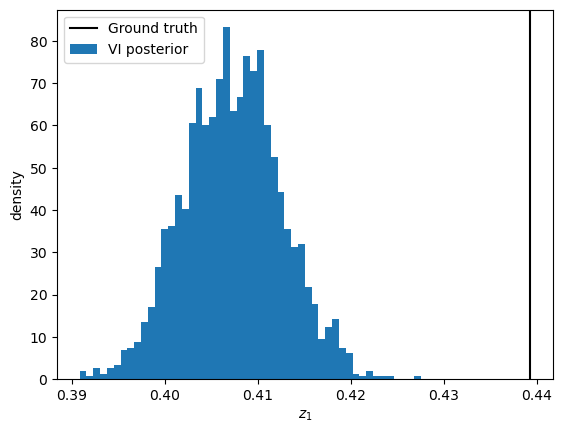

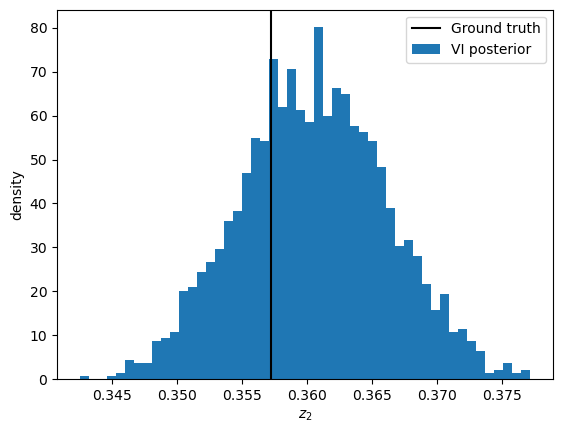

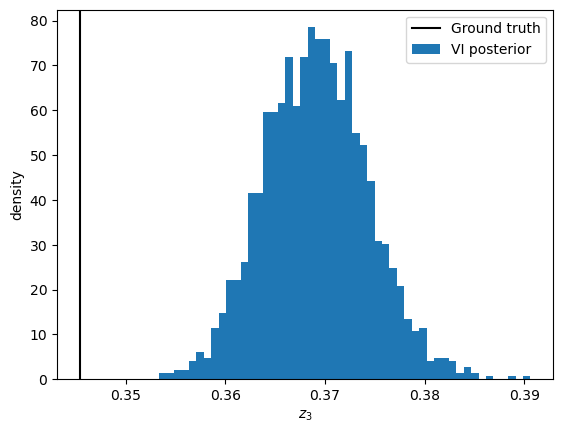

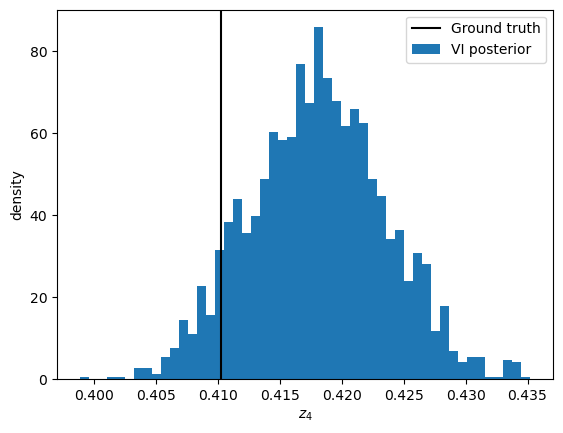

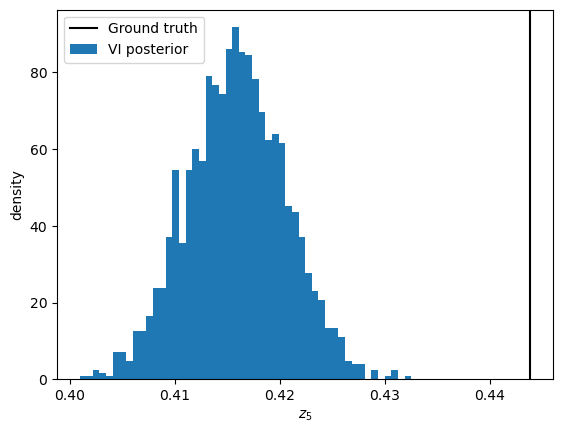

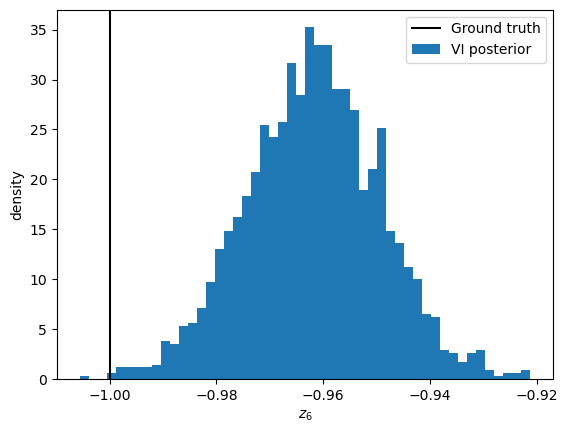

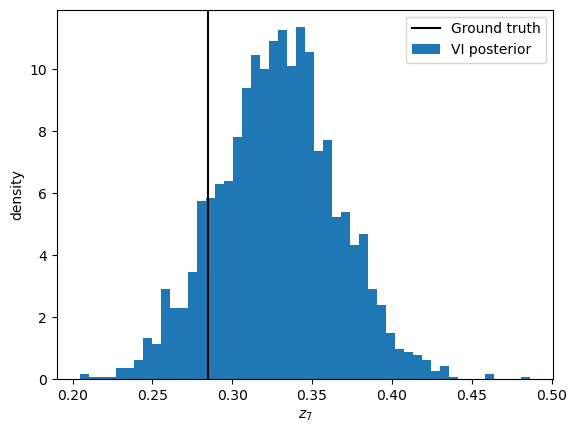

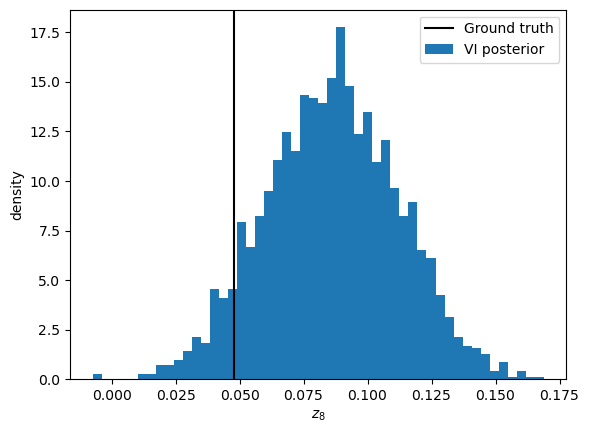

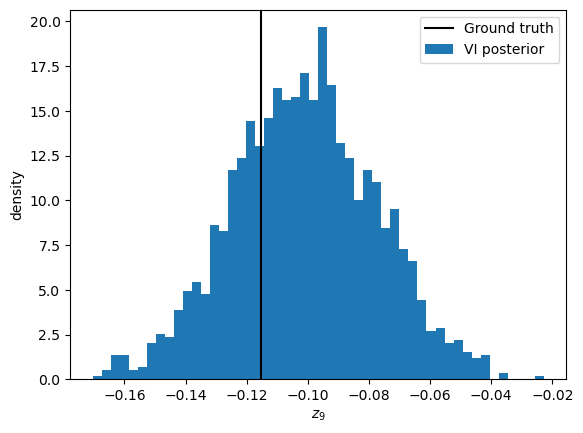

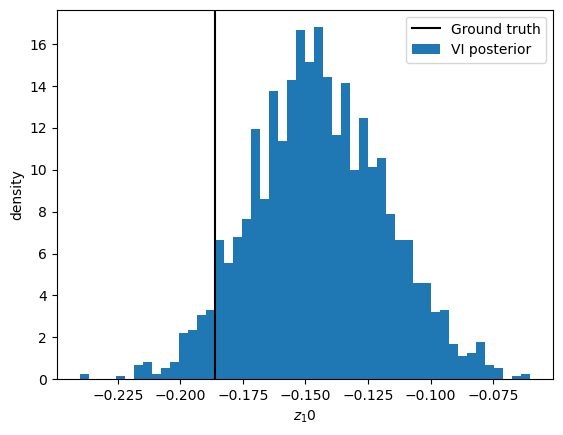

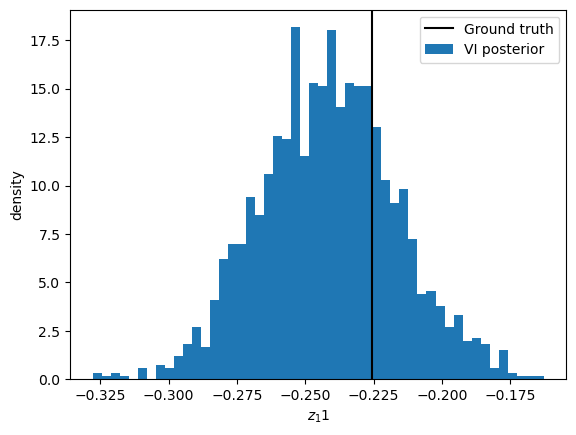

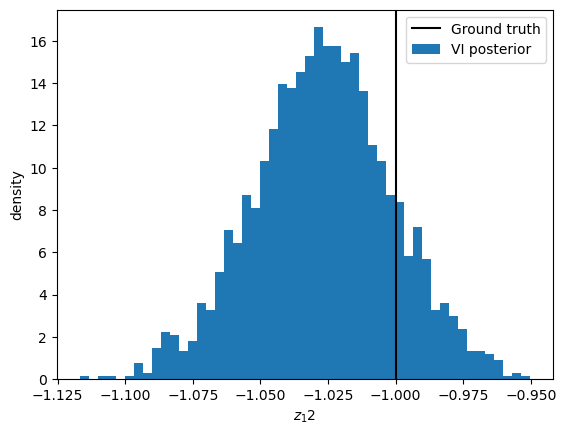

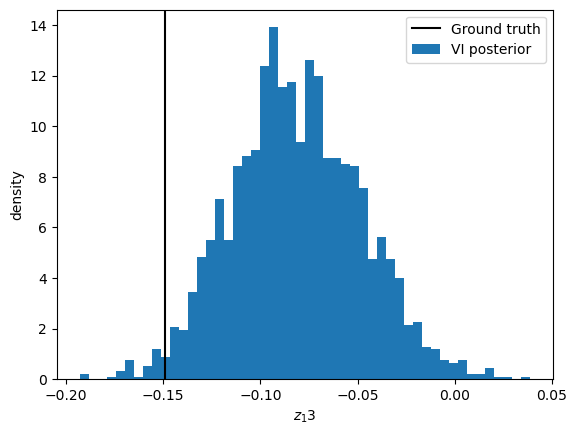

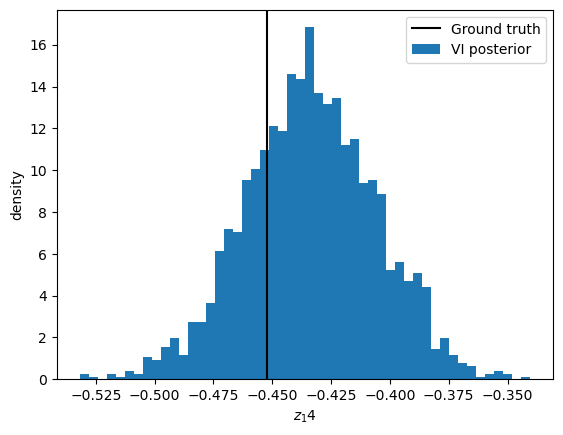

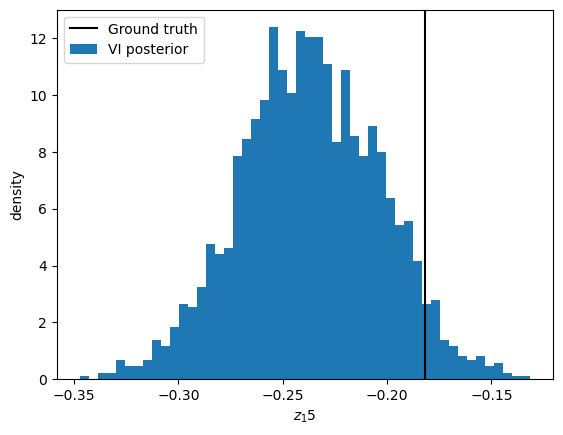

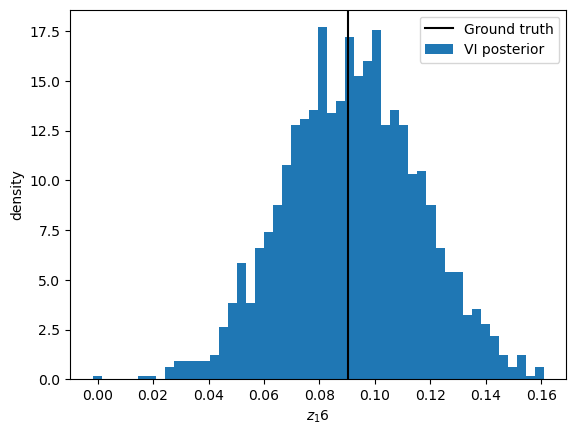

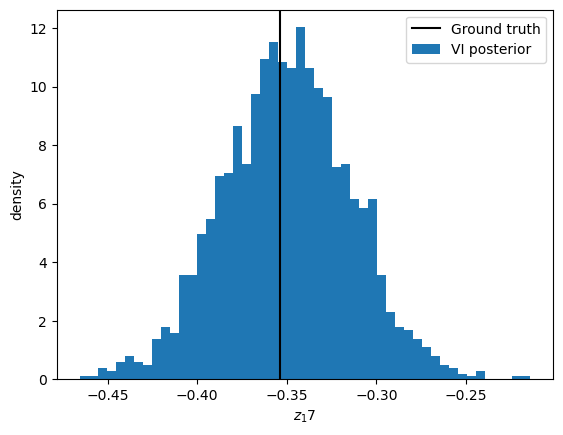

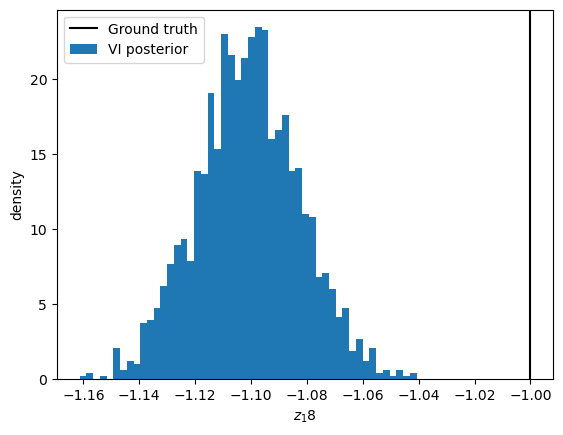

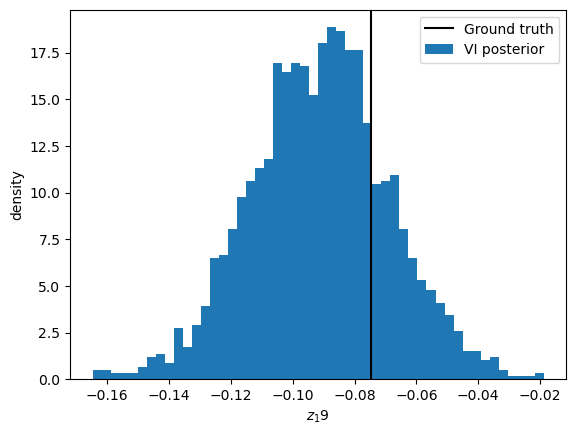

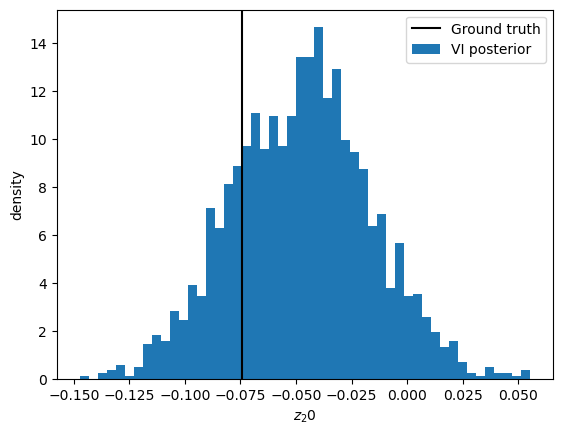

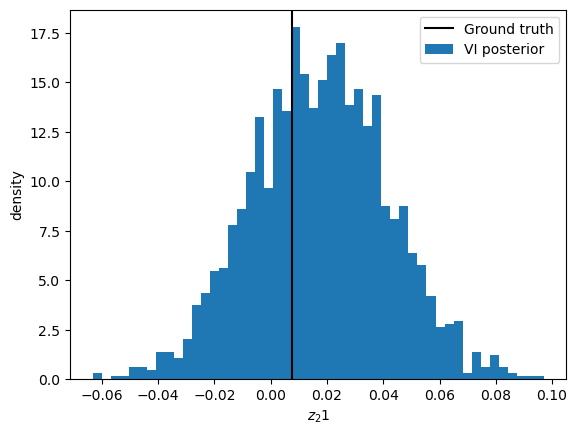

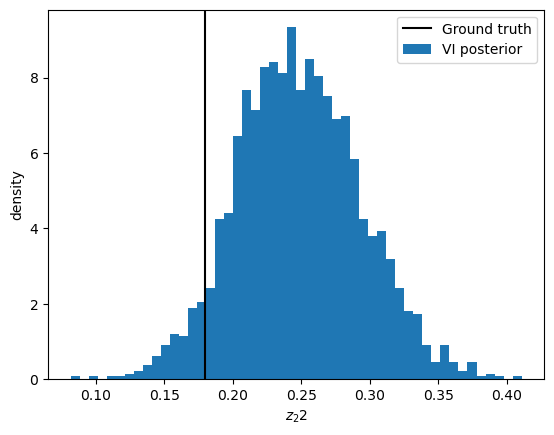

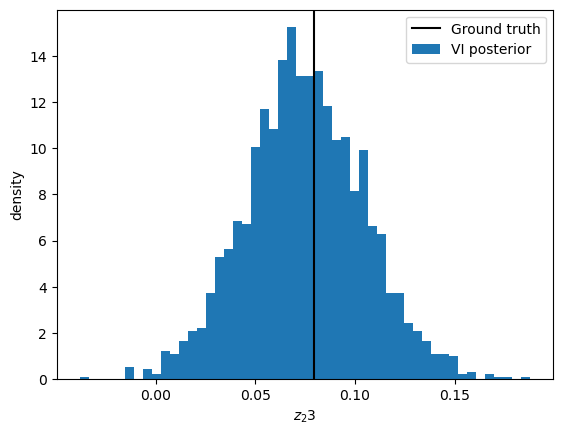

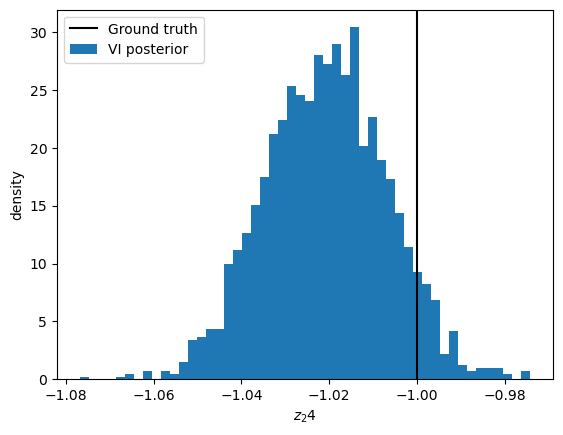

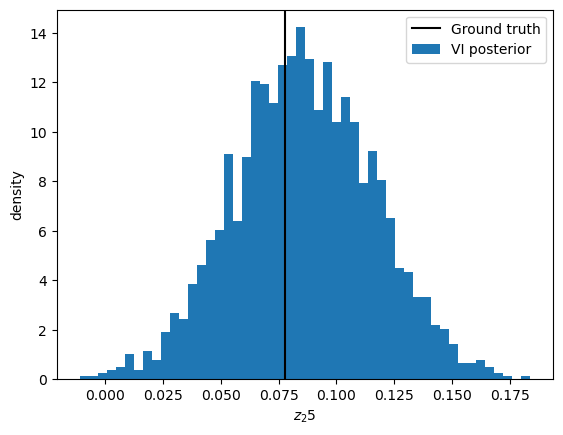

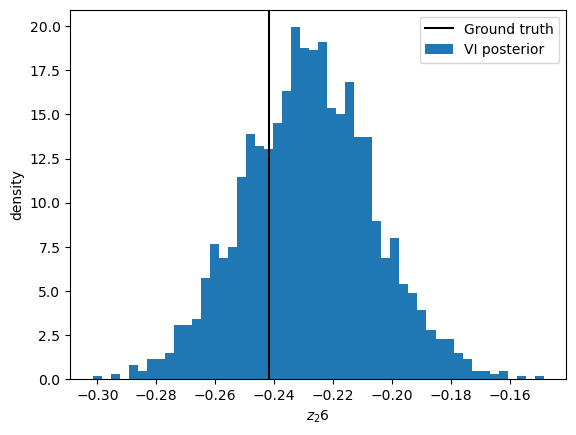

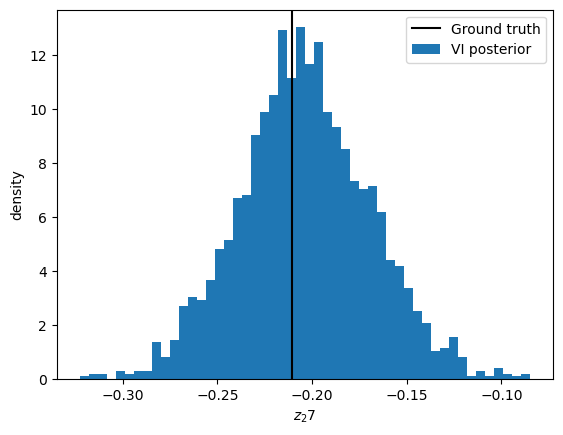

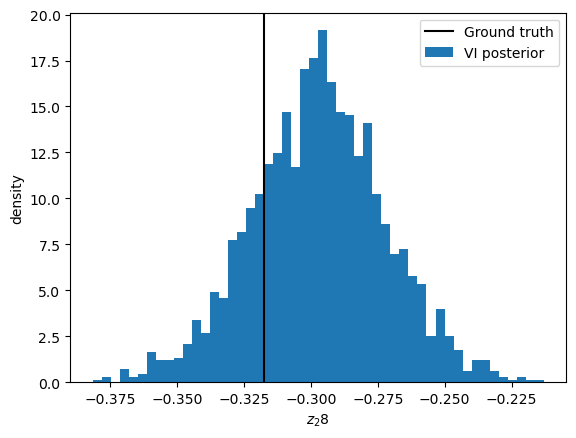

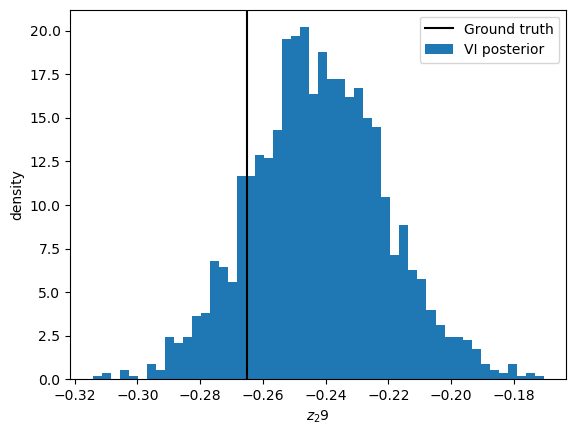

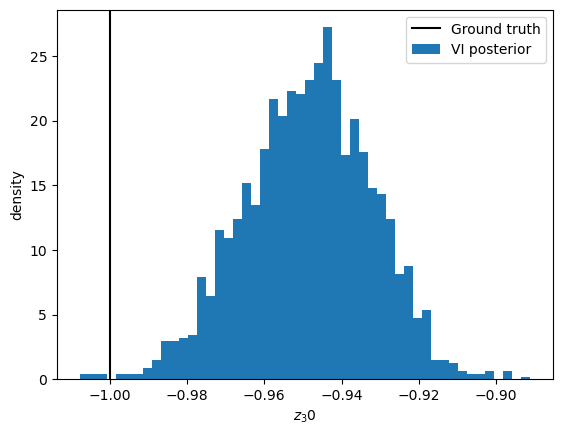

In [11]:
for i, z_true_i in enumerate(z_true):
    
    # plot NN posterior 
    plt.hist(np.array(z[:, i]), color='C0', bins=50, density=True, label='VI posterior')
    plt.axvline(x=z_true_i, c='k', label='Ground truth')
    
    plt.xlabel(f"$z_{i+1}$")
    plt.ylabel("density")
    plt.legend()
    plt.show()

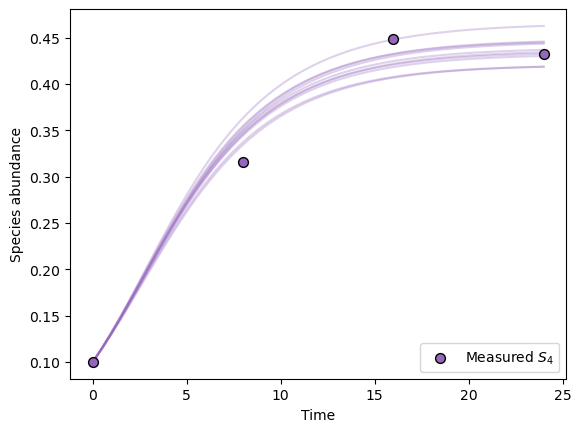

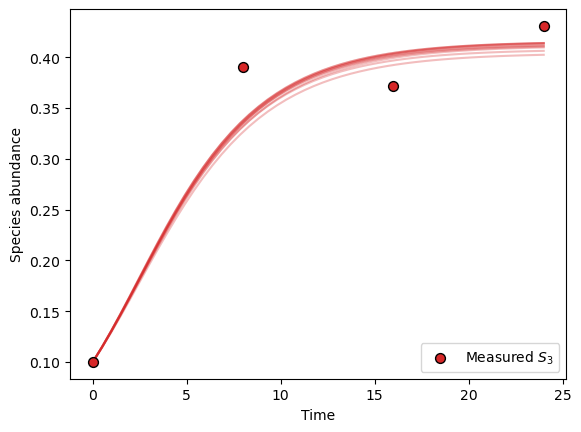

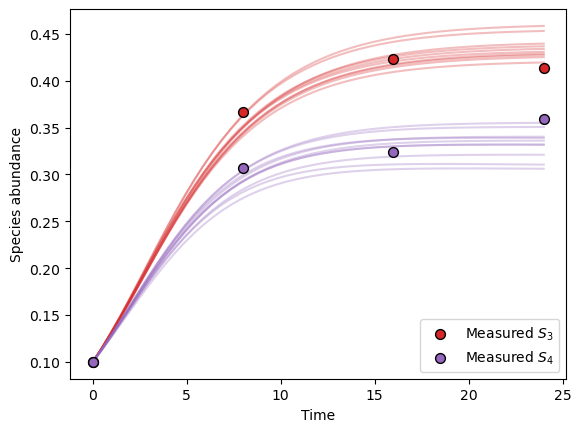

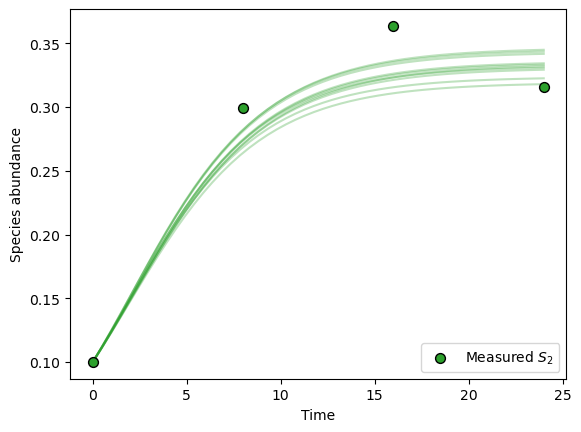

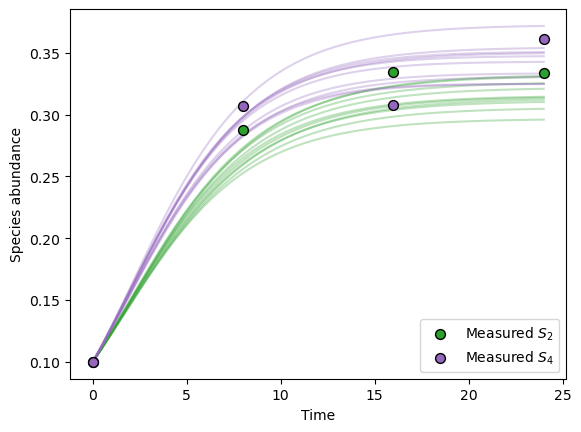

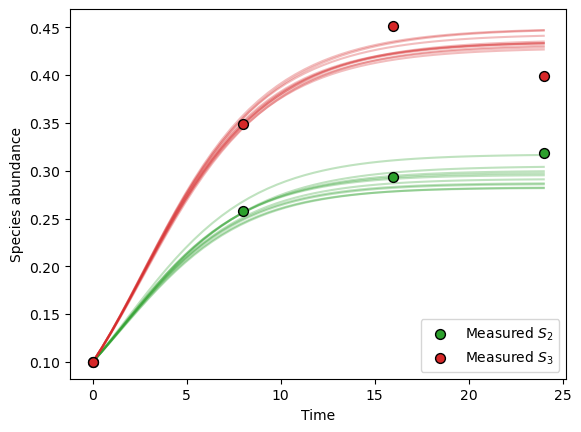

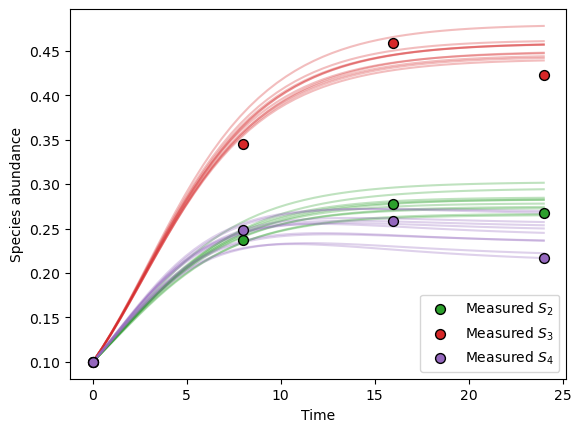

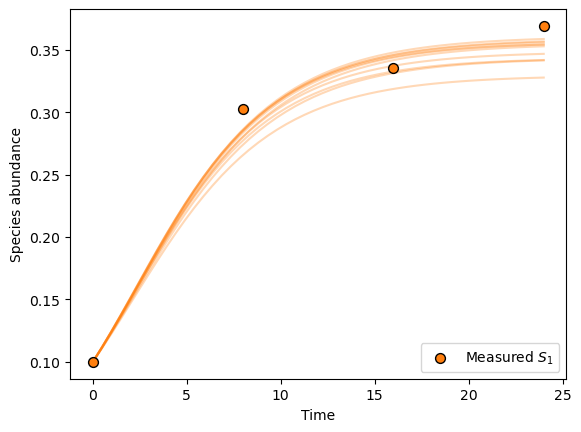

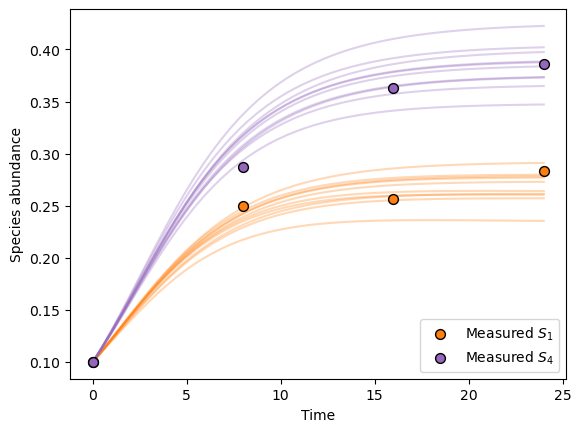

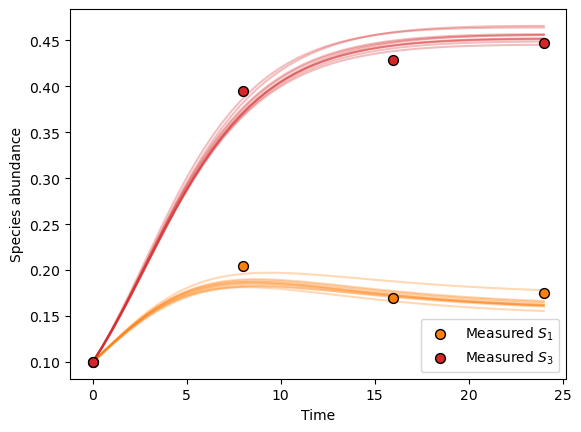

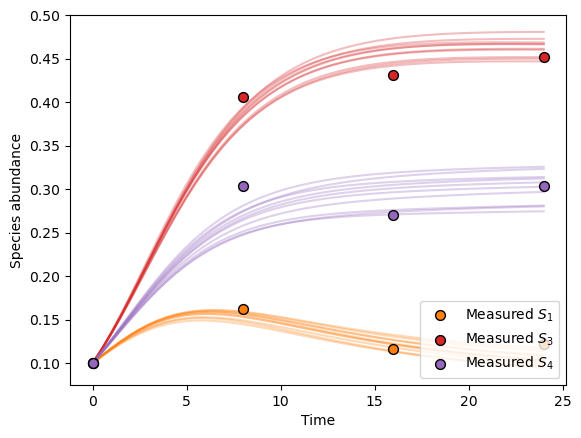

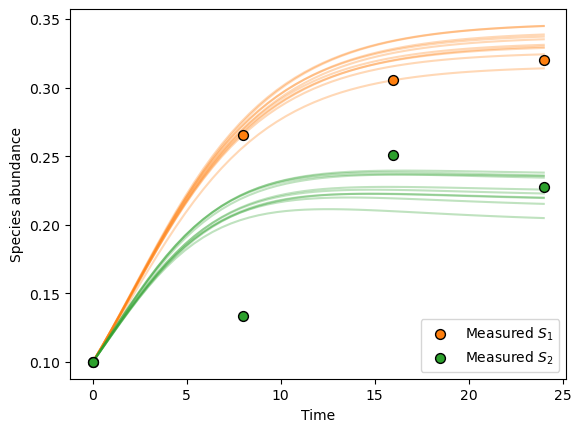

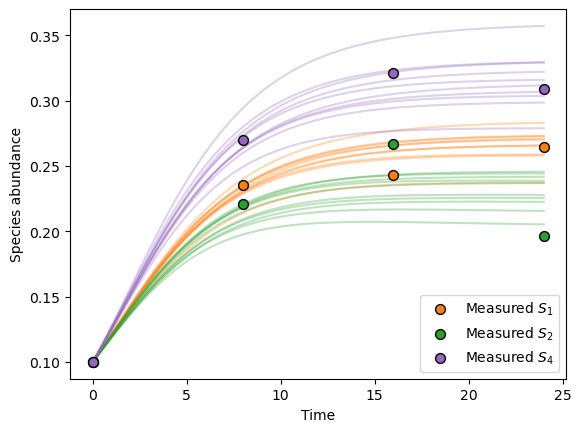

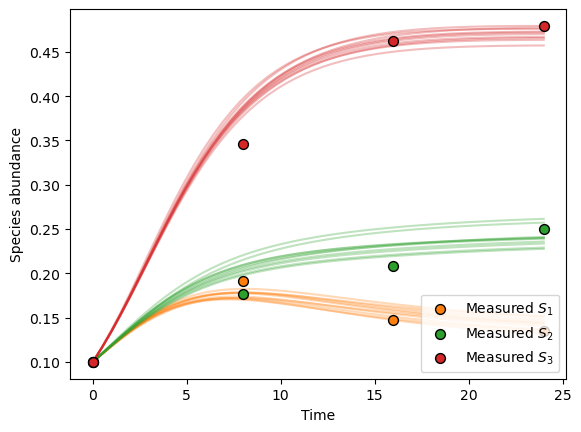

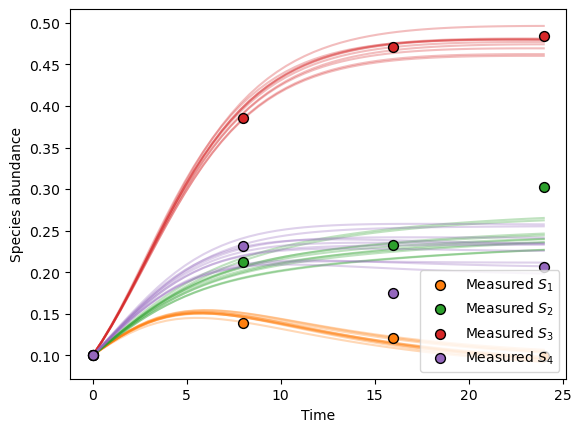

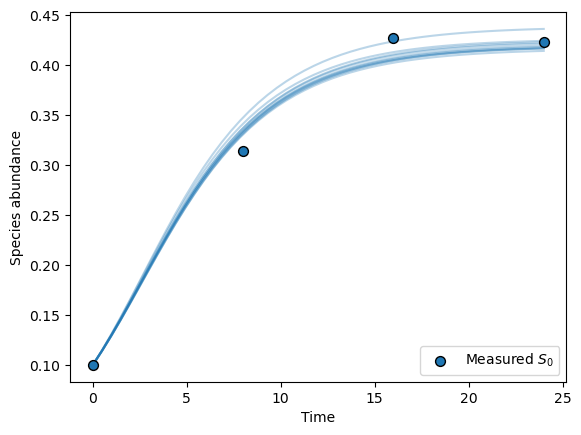

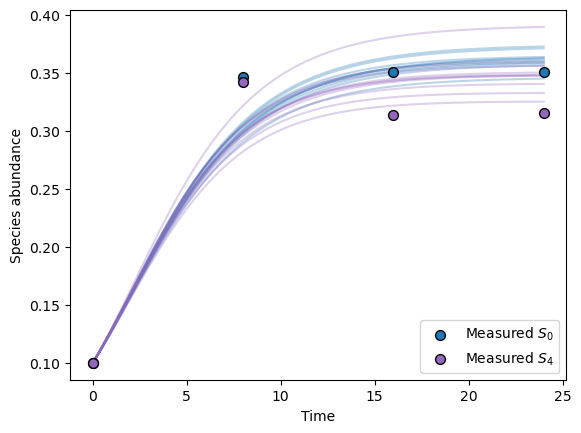

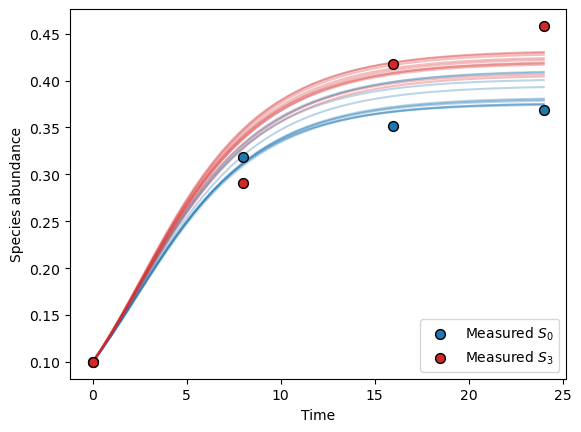

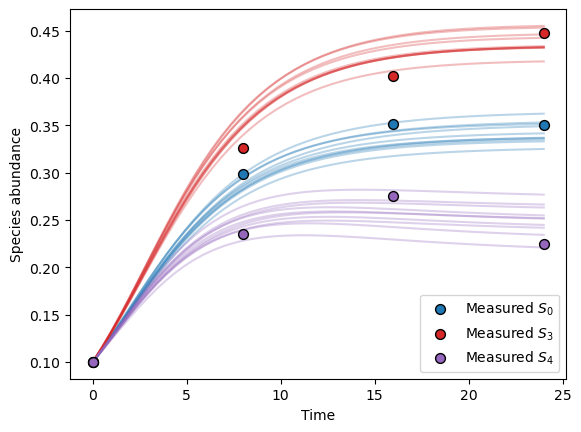

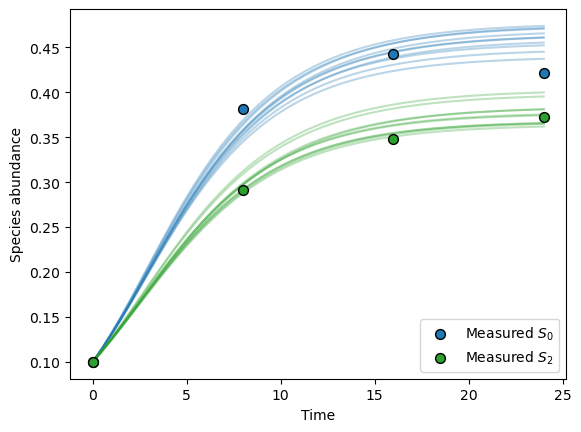

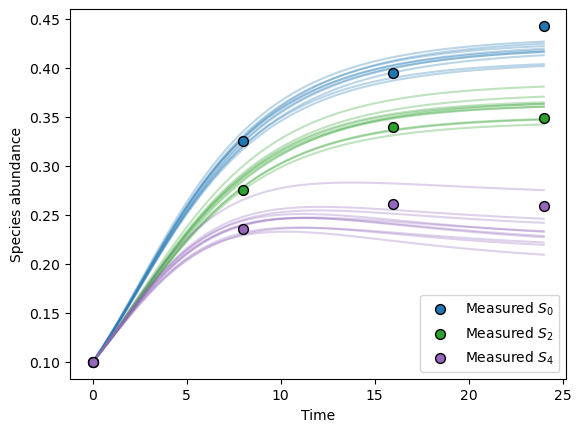

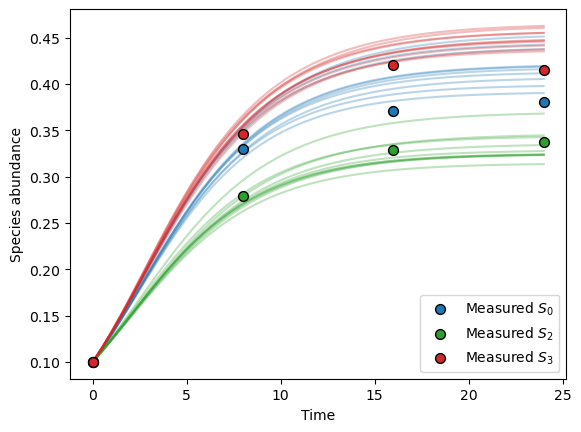

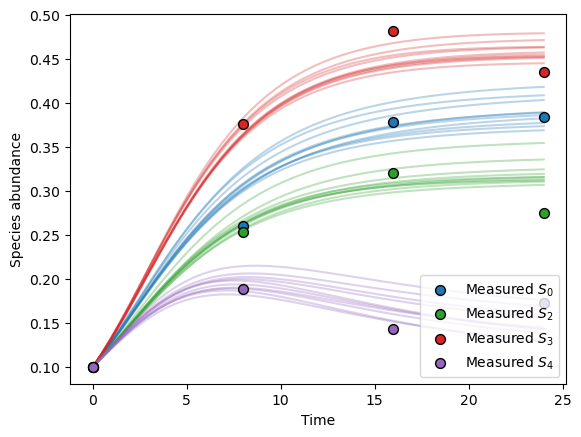

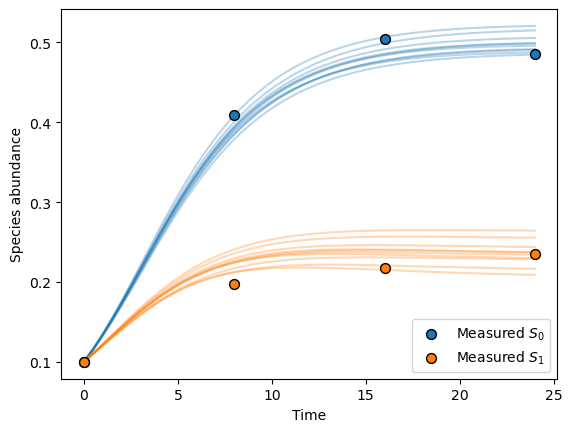

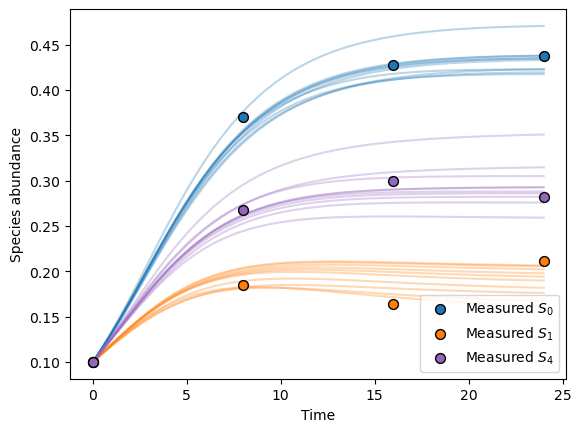

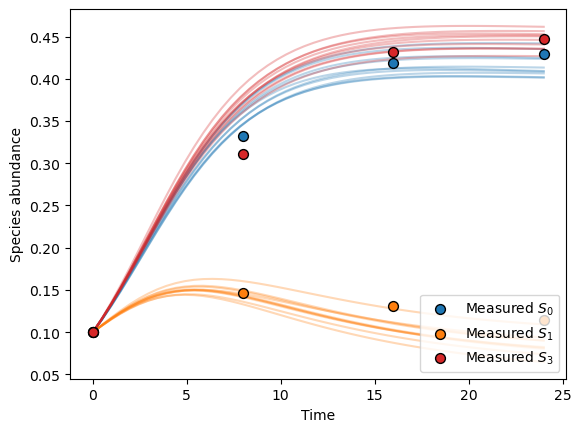

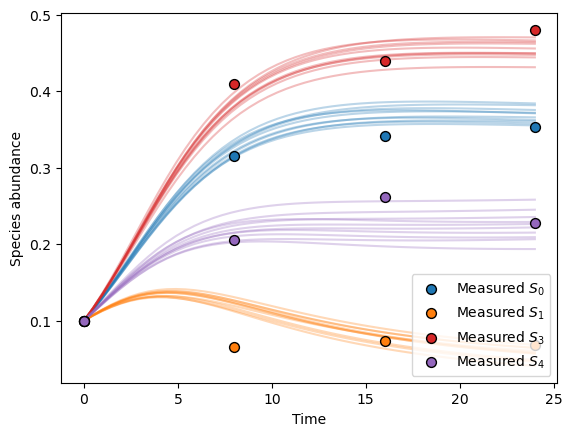

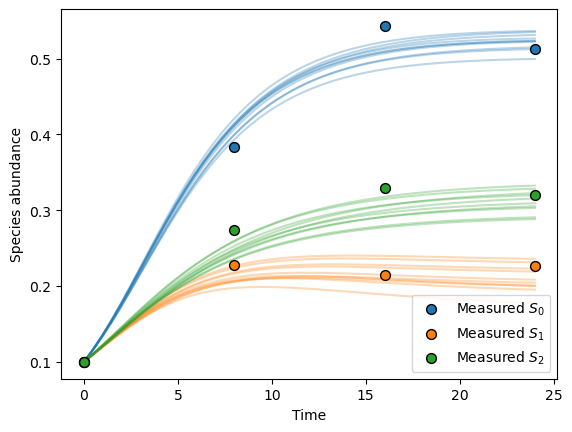

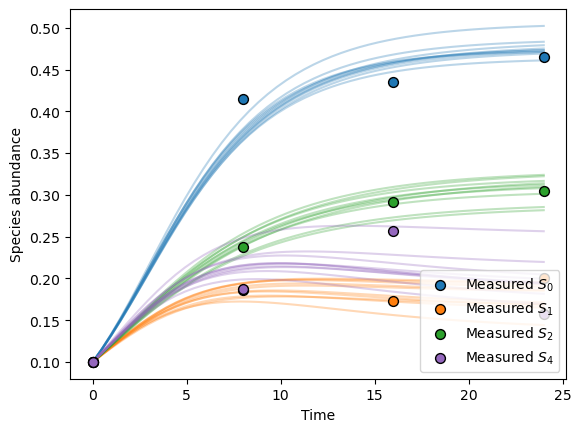

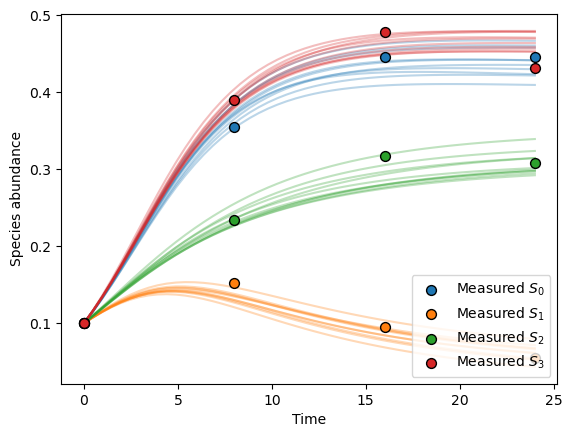

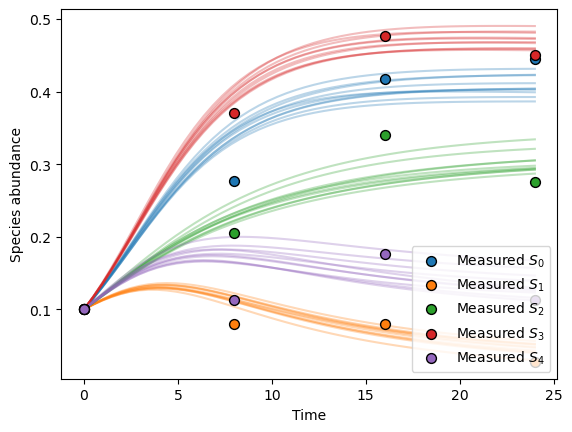

In [12]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(10, d)
z = batch_nn(y, lmbda)

# plot data 
for i in range(len(X)):

    # plt each species
    for j in range(n_s):
        if X[i][0,j] > 0:
            # plot data
            plt.scatter(t_span, X[i][:,j], c=f'C{j}', label=f"Measured $S_{j}$",
                        zorder=1, edgecolor='k', s=50)
            
            # plot samples from posterior
            for z_sample in z:
                x = odeint(gLV, X[i][0], np.linspace(t_span[0], t_span[-1]), z_sample)
                plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}', alpha=.3, zorder=0)
    plt.legend(loc='lower right')
    plt.ylabel("Species abundance")
    plt.xlabel("Time")
    plt.show()

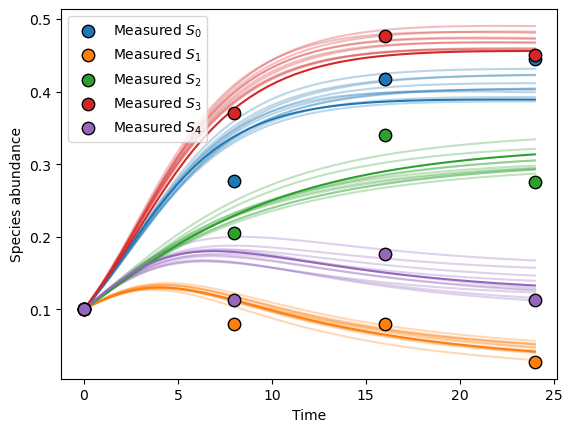

In [14]:
# pick condition
i = -1

# plt each species
for j in range(n_s):
    if X[i][0,j] > 0:
        # plot data
        plt.scatter(t_span, X[i][:,j], c=f'C{j}', label=f"Measured $S_{j}$",
                    zorder=2, edgecolor='k', s=80)

        # ground truth
        x = odeint(gLV_gt, X[i][0], np.linspace(t_span[0], t_span[-1]), z_true)
        plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}', alpha=1., zorder=1)
        
        # plot samples from posterior
        for z_sample in z:
            x = odeint(gLV, X[i][0], np.linspace(t_span[0], t_span[-1]), z_sample)
            plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}', alpha=.3, zorder=0)
plt.legend(loc='upper left')
plt.ylabel("Species abundance")
plt.xlabel("Time")
plt.savefig("figures/gLV_example.png")
plt.show()